# Lab 6: Convolutional Neural Networks


**Name(s):** Emmanuel Garcia, Nimai Keshu, Tiffany Nguyen, Luke Voinov

We use the Youtube Thumbnail Dataset:

https://www.kaggle.com/datasets/praneshmukhopadhyay/youtube-thumbnail-dataset/data

This dataset contains the most successful thumbnails from over 90 youtube channels. There are 9 genres of videos with 10 - 15 channels in each genre

Much of the code in this dataset was adapted from Eric Larson, 12a. More Advanced CNN Techniques as TFData.ipynb:

https://github.com/eclarson/MachineLearningNotebooks/blob/master/12a.%20More%20Advanced%20CNN%20Techniques%20as%20TFData.ipynb

We denote this reference with (1)

### 1. Pre-processing

In [28]:
# Import any dependencies

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print('Pandas:', pd.__version__)
print('Numpy:',np.__version__)
# Python: 3.12.3

Pandas: 2.2.2
Numpy: 2.0.2


In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
!find "/content/drive" -maxdepth 7 -type d -iname "thumbnails"

In [4]:
# This code was written by Github Copilot to get all the videos into one folder for convenience
# Change the path and output path. make sure the input path goes into the images folder so that it could look through each folder inside it.
# Use the ouput path "all_images" for processing. Use the metadata.csv to pair each video with its genre.

import os
import shutil

#path = r"/Users/tiffany/Desktop/CS 5324/Lab 6 - CNNs/thumbnails/images"
#all_videos_path = r"/Users/tiffany/Desktop/CS 5324/Lab 6 - CNNs/all_videos"
path = '/content/drive/My Drive/test/thumbnails/images'
all_videos_path = '/content/drive/My Drive/test/all_videos'

# Create the folder if it doesn't exist
if not os.path.exists(all_videos_path):
    os.makedirs(all_videos_path)

if len(os.listdir(all_videos_path)) == 0:
    total_copied = 0
    seen_filenames = set()

    # Iterate through each subfolder in the path
    for folder_name in os.listdir(path):
        folder_path = os.path.join(path, folder_name)

        # Only process if it's a directory
        if os.path.isdir(folder_path):
            # Get all files in this subfolder
            for file_name in os.listdir(folder_path):
                source_file = os.path.join(folder_path, file_name)

                # Only copy files, not subdirectories
                if os.path.isfile(source_file):
                    # Check if we've seen this filename before
                    if file_name in seen_filenames:
                        # Handle duplicate by adding folder prefix
                        name, ext = os.path.splitext(file_name)
                        new_file_name = f"{folder_name}_{file_name}"
                        destination_file = os.path.join(all_videos_path, new_file_name)
                        seen_filenames.add(new_file_name)
                    else:
                        destination_file = os.path.join(all_videos_path, file_name)
                        seen_filenames.add(file_name)

                    shutil.copy2(source_file, destination_file)
                    total_copied += 1

    print(f"Successfully copied {total_copied} files to:")
    print(f"{all_videos_path}")
else:
    print("all_videos already populated, skipping copy.")


all_videos already populated, skipping copy.


In [32]:
# this code is adapted from voinov_lab2.ipynb
# This code will list through every image in my folder and put it into a numpy array

import os
import numpy as np
from PIL import Image

# 'all' because there is no need to split between training and testing
source_dir = "/content/drive/My Drive/all_videos"

# This code looks inside my 'all' folder and finds all my images
files = sorted(os.listdir(source_dir))
print(f"Loading {len(files)} images as numpy arrays...")

# Load all images into a list of numpy arrays
images = []
for f in files:
    fpath = os.path.join(source_dir, f) # this allow me to access each image path to store each image as an array
    img_array = np.array(Image.open(fpath))
    images.append(img_array)

# Convert list to numpy array
images = np.array(images)
print(f"Loaded {len(images)} images")
print(f"Image array shape: {images.shape}")

Loading 2303 images as numpy arrays...
Loaded 2303 images
Image array shape: (2303, 720, 1280, 3)


In [33]:
# Code adapted from voinov_lab2.ipynb to scale image size down
# Adapted from github copilot to inlucde color channels
# Lareg images take longer to process
# We originally reduce each image to 64x64 and keep the color
# This code first reduces the pixel resolution of each image and then flattens each image

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import time

start_time = time.time()

# Get image dimensions from first image
print(f"Original image size: {images[0].shape}")

# convert to 32x32 pixels (RGB channels preserved automatically)
target_size = (64, 64)  # width, height only
print(f"Downsampling to: {target_size} (with 3 color channels)")

# number of features when flattened (64 * 64 * 3)
n_features = target_size[0] * target_size[1] * 3

# create a zero matrix that will store each image (rows) and has enough columns to store the number of features when each image is flattened
X = np.zeros((len(images), n_features), dtype=np.float32)

for i in range(len(images)):
    img = images[i]

    # Convert to RGB if image is grayscale or has alpha channel
    img_pil = Image.fromarray(img.astype(np.uint8))
    if img_pil.mode != 'RGB':
        img_pil = img_pil.convert('RGB')

    # resize to 32x32 (keeps 3 RGB channels)
    img_resized = img_pil.resize(target_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float32) / 255.0

    # each row stores the flattened array (32*32*3 = 3072 features)
    X[i] = img_array.flatten()

h, w = target_size  # Set dimensions for later use
end_time = time.time()
print(f"\nProcessing completed in {end_time - start_time:.2f} seconds")
print(f"Dataset shape: {X.shape}")
print(f"Each image is {h}x{w}x3 = {n_features} features")

Original image size: (720, 1280, 3)
Downsampling to: (64, 64) (with 3 color channels)

Processing completed in 24.51 seconds
Dataset shape: (2303, 12288)
Each image is 64x64x3 = 12288 features


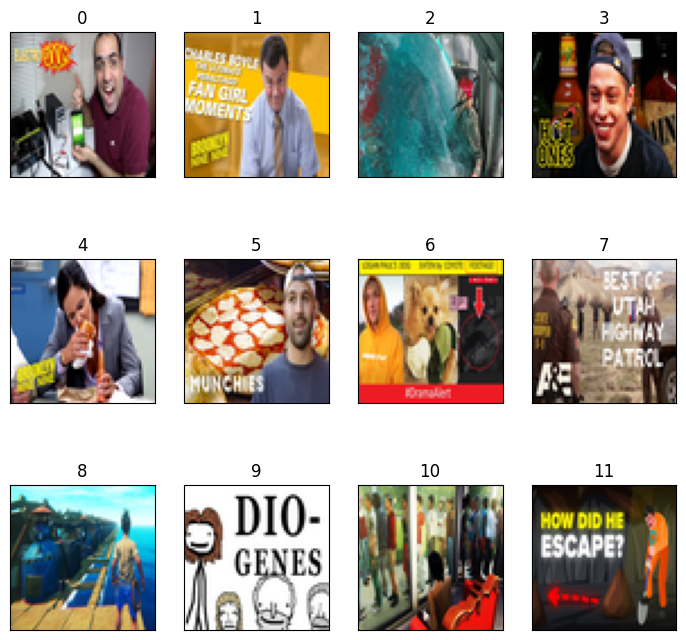

In [34]:
# Code adapted from voinov_lab2.ipynb to plot 12 images from our dataset

def plot_gallery(images, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of thumbnails"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        # Reshape to (h, w, 3) for color
        plt.imshow(images[i].reshape((h, w, 3)))
        plt.title(i, size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(X, h, w) # Note that X uses the 32x32 image resolution


2.1 *Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Mention why the data is similar to CIFAR and CIFAR's excellent business case (there isn't one). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.*


YouTube could use this dataset to automatically classify youtube videos by genre. Social media companies are always trying to make their recommendation algorithms better. If the algorithm could know the particular genres a user preferred, it could dramatically narrow down which videos it should recommend to the user. Thumbnails, along with other features of a video such as title and creator, would provide enough information about a video's genre. While this dataset does provide each thumbnail's content creator and title, for the purposes of this lab we will just look at how thumbnails (X) can be used to predict genre (y). Furthermore, using this information to classify genres is recommended because user will only click on a video if the thumbnail, content creator, and title are appealing. Thus, a recommendation system trained on these features would see things close to how a user sees them; it would be close to the real-life context.

Rather than just choosing a metric based off our expectations, we will think through which one might be better and test all of them to make sure.

The CNN would say the following about accuracy: "out of all the videos I was given, I classified this percentage as the correct genre". Thus, a score of 0.9 would mean that the CNN was able to classify 90% of the videos to their respective genres. This measurement could be meaningful. Because there are 9 genres in this dataset, class imbalance wouldn't be too large of an issue. If our CNN classified each video as only one genre, it would get a max accuracy of 1/9 = 11.1%. If it classified videos into 8 genres and ignored one completely, it could get near 90% accuracy. This wouldn't be too bad.

Precision would tell us how many videos belong to the genre they were classified to. For every video classified into the entertainment genre, how many are actually entertainment? This means that precision would help us detect how many false positives there are in the data. Recall does the opposite and helps us predict how mnay false negatives there are.

Now it remains to consider what this system want to achieve and what conditions it should strive to avoid. The goal of this system is to correctly classify each thumbnail to its genre. Would it matter too much if the CNN incorrectly classified one genre (cooking, say) as a different one (gaming, say)? This would be an example of a false positive. If a user preferred gaming videos, and, while looking at their recommendations, saw a cooking video, would this be too harmful? Not at all, as long as the system classifies the majority of the thumbnails as 'gaming' and this cooking video is an outlier. At an extreme, however, the user would be severely dissatisfied if the system recommended mainly cooking videos. Therefore false positives should be punished to the extent that they're only rarely classified as such.

Would it matter if a 'gaming' video was consistently misclassified as non-gaming? This would be a false negative. That would mean that the user would never see that video from recommendations alone. This is a greater problem as it could have fueled greater engagement. While recommending the occassional cooking video could allow the system to catch changing preferences, the user is more likely to click on videos within their favorite genre. Since this is what the system wants, false negatives should be taken more seriosly than false positives.

Taken together, recall is slighly more important than precision because false negatives are more important to avoid. Precision also plays an important role though. Thus, F_beta would be a good measurement metric since it combines both precision and recall and allows us to weigh one as more imporatant than the other. Here, beta > 1, to give more importance to recall. Beta can be somehting between 2 or 3 because recall shouldn't have too much of an edge over precision.

We choose F_3 and recall as our primary evalutation metrics. We will visualize with confusion matricies.

**2.2 Train & Test Split Dataset**

 Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method, as appropriate. Convince me that your splitting method is a realistic mirroring of how an algorithm would be used in practice.

The method that we will be using to divide our data into training and testing is a **stratified shuffle split**. Why? Our dataset contains multiple YouTube categories (some examples include: Science, Entertainment, Gaming, etc.), so a simple random split may create an unbalanced test set, overrepresenting some categories while under-representing some others.

If we use stratification, each category would appear in the training and test sets in the same proportion as the full dataset. No category here is lost or underrepresented in the test set. This is important because thumbnails vary widely across genres. An example, if "Science" videos appeared heavily in he training set but were rarely represented in the test set, the model's generalization performance would be unreliable.

Here, we are doing a 80/20 split (80% training and 20% being testintg), which is common especially with how we are using our dataset. A 20% test set is large enough to evaluate model performance across all categories, hence why we chose this as it provides sufficient training data for learning and sufficient test data for evaluation.

The YouTube thumbnails in the dataset are grouped by channel in the original folder, so we would be required to shuffle the dataset. What shuffling does for us is that it ensures the model sees a more randomized and diverse sample of thumbnails during training, preventing bias due to ordering effects.

This approach of using stratified shuffle split would best reflect how a real Youtube-style classification model would be developed and evaluated in practice.

First, I want to check out this metadata.csv file out. Let's see what it has to provide for us.

In [35]:
# Imported from Github Copilot to help with reading the metadata file

# load metadata
metadata_path = "/content/drive/My Drive/metadata.csv"   # change if needed
df = pd.read_csv(metadata_path)

print(df.head())

            Id      Channel Category  \
0  OkmNXy7er84  3Blue1Brown  Science   
1  r6sGWTCMz2k  3Blue1Brown  Science   
2  bBC-nXj3Ng4  3Blue1Brown  Science   
3  aircAruvnKk  3Blue1Brown  Science   
4  HEfHFsfGXjs  3Blue1Brown  Science   

                                               Title  
0            The hardest problem on the hardest test  
1  But what is a Fourier series? From heat flow t...  
2                But how does bitcoin actually work?  
3  But what is a neural network? | Chapter 1, Dee...  
4    The most unexpected answer to a counting puzzle  


I notice 3 columns, the Id, Channel, and the Category! This is going to be good for us so we can see the genres and also see the channels they're coming from.

In [36]:
# Adapted from Github Copilot

files = sorted(os.listdir(source_dir))

# remove extensions so we can match "OkmNXy7er84" to "OkmNXy7er84.jpg"
file_ids = [os.path.splitext(f)[0] for f in files]

y = []
for fid in file_ids:
    # look up category in metadata where Id matches file name (without extension)
    genre = df.loc[df['Id'] == fid, 'Category'].values[0]
    y.append(genre)

y = np.array(y)
print("Labels created. Shape:", y.shape)


Labels created. Shape: (2303,)


Let's finally split the dataset accordingly!

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 1842
Test size: 461


Now that it has been split accordingly, we should be prepared to go into Modeling.

### 3. Modeling

Prep for CNN modeling

In [72]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
X_train_cnn = X_train.reshape(-1, 64, 64, 3)
X_test_cnn = X_test.reshape(-1, 64, 64, 3)
le = LabelEncoder()
y_train_int = le.fit_transform(y_train)
y_test_int = le.transform(y_test)
NUM_CLASSES = len(le.classes_)

# MODIFIED with Chat GPT 5
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
ds_train = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_int))
ds_train = ds_train.shuffle(len(X_train_cnn), seed=42).batch(batch_size).prefetch(AUTOTUNE)
ds_val = tf.data.Dataset.from_tensor_slices((X_test_cnn, y_test_int))
ds_val = ds_val.batch(batch_size).prefetch(AUTOTUNE)

# Debugging
for batch_images, batch_labels in ds_train.take(1):
    print(batch_labels[:20])
    print(batch_labels.dtype)
print("NUM_CLASSES =", NUM_CLASSES)
all_labels = []
for _, y_batch in ds_train.take(1000):
    all_labels.append(y_batch.numpy())
all_labels = np.concatenate(all_labels)
print("Unique labels:", np.unique(all_labels))
print("Count:", len(np.unique(all_labels)))


tf.Tensor([ 2 12 12  9 17 14 12 21 16  8  7 11 12  1  7 21  7 14 16 17], shape=(20,), dtype=int64)
<dtype: 'int64'>
NUM_CLASSES = 22
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
Count: 22


Data Augmentation

In [73]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.05),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomBrightness(0.1, value_range=(0,1)),
    layers.RandomContrast(0.1),
], name="augmentation_block")


For the augments we selected the horizontal flip. This prevents the model from learning patterns that are position specific and it teaches the model that orientation shouldn't determine class. We added a slight rotation as well since creators rotate elements in the thumbnails. It displays small camera angle variations. We also added a random translation that shifts the images up to 10 percent in both heigh and width since in thumbnails the elements arent perfectly centered. This makes it so the CNN doesn't rely on the locations of exact pixels. We added random brightness that slightly increases or decreases brightness since thumbnails have different lighting depending on who posted it and the genre. This prevents overfitting to specific lighting conditions. Then we added random contrast to higher or lower the contrast since it varies widely across thumbnails from filters, etc. This augmentation teaches the network to focus on shapes and structure rather than the exact colors.

Additional Models

In [40]:
def create_cnn_model(model_name,
                     input_shape=(64,64,3),
                     kernel_size=(3,3),
                     pool_size=(2,2),
                     filters_per_conv_layer=[32],
                     dense_layer_sizes=[128],
                     num_classes=9,
                     use_dropout=False):

    cnn = Sequential(name=model_name)
    cnn.add(Input(input_shape))

    for num_filters in filters_per_conv_layer:
        cnn.add(Conv2D(filters=num_filters,
                       kernel_size=kernel_size,
                       padding='same',
                       activation='relu'))
        cnn.add(MaxPooling2D(pool_size=pool_size))

    cnn.add(Flatten())
    for num_hidden in dense_layer_sizes:
        cnn.add(Dense(num_hidden, activation='relu'))
        if use_dropout:
            cnn.add(Dropout(0.5))

    cnn.add(Dense(num_classes, activation='softmax'))

    return cnn

# create_advanced_cnn generated by ChatGPT
def create_advanced_cnn(model_name="advanced_cnn", input_shape=(64, 64, 3),
                        num_classes=10, data_augmentation=None, kernel_size=(3,3),
                        pool_size=(2,2), residual_filters=32, final_conv_filters=64,
                        dense_hidden_units=128, use_separable=True, use_dropout=True,
                        dropout_rate=0.5):

    ConvLayer = SeparableConv2D if use_separable else Conv2D

    inp = Input(shape=input_shape, name=f"{model_name}_input")
    x = inp

    if data_augmentation is not None:
        x = data_augmentation(x)

    x = Conv2D(residual_filters, kernel_size, padding='same', activation='relu',
               name=f"{model_name}_conv1")(x)
    x = MaxPooling2D(pool_size=pool_size, name=f"{model_name}_pool1")(x)

    res = x

    x = ConvLayer(residual_filters, kernel_size, padding='same', activation='relu',
                  name=f"{model_name}_res_conv_a")(x)
    x = ConvLayer(residual_filters, kernel_size, padding='same', activation='relu',
                  name=f"{model_name}_res_conv_b")(x)

    x = Add(name=f"{model_name}_add")([x, res])
    x = Activation('relu', name=f"{model_name}_add_relu")(x)
    x = MaxPooling2D(pool_size=pool_size, name=f"{model_name}_pool_after_res")(x)

    x = Conv2D(final_conv_filters, kernel_size, padding='same', activation='relu',
               name=f"{model_name}_conv2")(x)
    x = MaxPooling2D(pool_size=pool_size, name=f"{model_name}_pool2")(x)

    x = Flatten(name=f"{model_name}_flatten")(x)
    if use_dropout:
        x = Dropout(dropout_rate, name=f"{model_name}_dropout")(x)

    x = Dense(dense_hidden_units, activation='relu', name=f"{model_name}_dense")(x)
    outputs = Dense(num_classes, activation='softmax', name=f"{model_name}_output")(x)

    model = Model(inputs=inp, outputs=outputs, name=model_name)
    return model

In [41]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, SeparableConv2D
from tensorflow.keras.layers import Concatenate, Add, Reshape, Input
cnn1 = create_cnn_model(
    model_name = "cnn1",
    input_shape = (64,64,3),
    kernel_size = (3,3),
    pool_size   = (2,2),
    filters_per_conv_layer = [32,64],
    dense_layer_sizes      = [128],
    num_classes            = NUM_CLASSES,
    use_dropout            = True
)

cnn2 = create_advanced_cnn(
    model_name = "cnn2",
    input_shape = (64,64,3),
    num_classes = NUM_CLASSES,
    kernel_size = (3,3),
    data_augmentation = data_augmentation,
    residual_filters  = 32,
    final_conv_filters= 64,
    dense_hidden_units= 128,
    use_dropout       = True
)

cnn3 = create_cnn_model(
    model_name = "cnn3",
    input_shape = (64,64,3),
    kernel_size = (3,3),
    pool_size   = (2,2),
    filters_per_conv_layer = [32,64,64],
    dense_layer_sizes      = [128,100],
    num_classes            = NUM_CLASSES,
    use_dropout            = True
)

cnn4 = create_advanced_cnn(
    model_name = "cnn4",
    input_shape = (64,64,3),
    num_classes = NUM_CLASSES,
    kernel_size = (3,3),
    data_augmentation = data_augmentation,
    residual_filters  = 64,
    final_conv_filters= 128,
    dense_hidden_units= 128,
    use_dropout       = True
)

for model in [cnn1, cnn3]:
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(beta_1=.9, beta_2=.999, learning_rate=1e-4),
        metrics=['accuracy']
    )
    print(model.summary())
    model.fit(
        ds_train,
        epochs=50,
        verbose=1,
        validation_data=ds_val
    )

for model in [cnn2, cnn4]:
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=keras.optimizers.Adam(beta_1=.9, beta_2=.999, learning_rate=1e-4),
        metrics=['accuracy']
    )
    print(model.summary())
    model.fit(
        ds_train,
        epochs=50,
        verbose=1,
        validation_data=ds_val
    )

Model: "cnn1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,119,510 (8.09 MB)

 Trainable params: 2,119,510 (8.09 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.1098 - loss: 2.9478 - val_accuracy: 0.1605 - val_loss: 2.7370
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1595 - loss: 2.7574 - val_accuracy: 0.2516 - val_loss: 2.6735
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2030 - loss: 2.6485 - val_accuracy: 0.2646 - val_loss: 2.5713
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2292 - loss: 2.5735 - val_accuracy: 0.2560 - val_loss: 2.4988
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2651 - loss: 2.4639 - val_accuracy: 0.2885 - val_loss: 2.4702
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2900 - loss: 2.3854 - val_accuracy: 0.3189 - val_loss: 2.3839
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3033 - loss: 2.3424 - val_accuracy: 0.3362 - val_loss: 2.3672
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3419 - loss: 2.2289 - val_accuracy: 0.3514 - val

Model: "cnn3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │       524,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 100)            │        12,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 22)             │         2,222 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 595,858 (2.27 MB)

 Trainable params: 595,858 (2.27 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 63ms/step - accuracy: 0.0904 - loss: 3.0373 - val_accuracy: 0.1106 - val_loss: 2.9147
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.1122 - loss: 2.9594 - val_accuracy: 0.1150 - val_loss: 2.8855
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.0922 - loss: 2.9518 - val_accuracy: 0.1280 - val_loss: 2.8511
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1136 - loss: 2.8916 - val_accuracy: 0.1280 - val_loss: 2.8144
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1325 - loss: 2.8543 - val_accuracy: 0.1627 - val_loss: 2.7917
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.1446 - loss: 2.8289 - val_accuracy: 0.1887 - val_loss: 2.7642
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1385 - loss: 2.8230 - val_accuracy: 0.1735 - val_loss: 2.7167
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.1673 - loss: 2.7570 - val_accuracy: 0.1844 - val

Model: "cnn2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn2_input          │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_block  │ (None, 64, 64, 3) │          0 │ cnn2_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_conv1 (Conv2D) │ (None, 64, 64,    │        896 │ augmentation_blo… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_pool1          │ (None, 32, 32,    │          0 │ cnn2_conv1[0][0]  │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_res_conv_a     │ (None, 32, 32,    │      1,344 │ cnn2_pool1[0][0]  │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_res_conv_b     │ (None, 32, 32,    │      1,344 │ cnn2_res_conv_a[… │
│ (SeparableConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_add (Add)      │ (None, 32, 32,    │          0 │ cnn2_res_conv_b[… │
│                     │ 32)               │            │ cnn2_pool1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_add_relu       │ (None, 32, 32,    │          0 │ cnn2_add[0][0]    │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_pool_after_res │ (None, 16, 16,    │          0 │ cnn2_add_relu[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_conv2 (Conv2D) │ (None, 16, 16,    │     18,496 │ cnn2_pool_after_… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_pool2          │ (None, 8, 8, 64)  │          0 │ cnn2_conv2[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_flatten        │ (None, 4096)      │          0 │ cnn2_pool2[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_dropout        │ (None, 4096)      │          0 │ cnn2_flatten[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_dense (Dense)  │ (None, 128)       │    524,416 │ cnn2_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn2_output (Dense) │ (None, 22)        │      2,838 │ cnn2_dense[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 549,334 (2.10 MB)

 Trainable params: 549,334 (2.10 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1028 - loss: 2.9403 - val_accuracy: 0.1518 - val_loss: 2.7705
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1557 - loss: 2.7432 - val_accuracy: 0.1779 - val_loss: 2.7161
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.1758 - loss: 2.7342 - val_accuracy: 0.2017 - val_loss: 2.6762
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2237 - loss: 2.6817 - val_accuracy: 0.2061 - val_loss: 2.6238
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2286 - loss: 2.6278 - val_accuracy: 0.2343 - val_loss: 2.6044
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2079 - loss: 2.6169 - val_accuracy: 0.2386 - val_loss: 2.5682
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2244 - loss: 2.5177 - val_accuracy: 0.2646 - val_loss: 2.5341
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2482 - loss: 2.5276 - val_accuracy: 0.2495 - val

Model: "cnn4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ cnn4_input          │ (None, 64, 64, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_block  │ (None, 64, 64, 3) │          0 │ cnn4_input[0][0]  │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_conv1 (Conv2D) │ (None, 64, 64,    │      1,792 │ augmentation_blo… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_pool1          │ (None, 32, 32,    │          0 │ cnn4_conv1[0][0]  │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_res_conv_a     │ (None, 32, 32,    │      4,736 │ cnn4_pool1[0][0]  │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_res_conv_b     │ (None, 32, 32,    │      4,736 │ cnn4_res_conv_a[… │
│ (SeparableConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_add (Add)      │ (None, 32, 32,    │          0 │ cnn4_res_conv_b[… │
│                     │ 64)               │            │ cnn4_pool1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_add_relu       │ (None, 32, 32,    │          0 │ cnn4_add[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_pool_after_res │ (None, 16, 16,    │          0 │ cnn4_add_relu[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_conv2 (Conv2D) │ (None, 16, 16,    │     73,856 │ cnn4_pool_after_… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_pool2          │ (None, 8, 8, 128) │          0 │ cnn4_conv2[0][0]  │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_flatten        │ (None, 8192)      │          0 │ cnn4_pool2[0][0]  │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_dropout        │ (None, 8192)      │          0 │ cnn4_flatten[0][… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_dense (Dense)  │ (None, 128)       │  1,048,704 │ cnn4_dropout[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cnn4_output (Dense) │ (None, 22)        │      2,838 │ cnn4_dense[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,136,662 (4.34 MB)

 Trainable params: 1,136,662 (4.34 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.1176 - loss: 2.9245 - val_accuracy: 0.1692 - val_loss: 2.7474
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.1464 - loss: 2.7633 - val_accuracy: 0.2191 - val_loss: 2.6972
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2112 - loss: 2.6808 - val_accuracy: 0.1779 - val_loss: 2.6459
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2090 - loss: 2.6670 - val_accuracy: 0.2321 - val_loss: 2.6043
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2271 - loss: 2.5619 - val_accuracy: 0.2234 - val_loss: 2.5524
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2347 - loss: 2.5405 - val_accuracy: 0.2386 - val_loss: 2.5562
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2367 - loss: 2.5076 - val_accuracy: 0.2560 - val_loss: 2.5279
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2761 - loss: 2.4327 - val_accuracy: 0.240

Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8247 - loss: 0.5950 - val_accuracy: 0.4403 - val_loss: 2.1035
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8488 - loss: 0.5368 - val_accuracy: 0.4425 - val_loss: 2.1264
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8547 - loss: 0.4985 - val_accuracy: 0.4447 - val_loss: 2.1991
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8582 - loss: 0.5155 - val_accuracy: 0.4382 - val_loss: 2.1925
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8564 - loss: 0.4982 - val_accuracy: 0.4512 - val_loss: 2.1525
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8723 - loss: 0.4918 - val_accuracy: 0.4534 - val_loss: 2.1897
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8861 - loss: 0.4576 - val_accuracy: 0.4534 - val_loss: 2.2111
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8697 - loss: 0.4542 - val_accuracy: 0.4664 - val_loss:

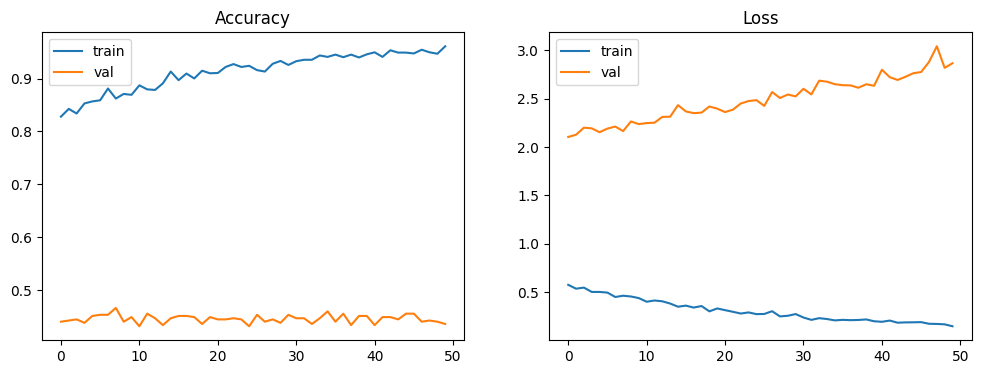

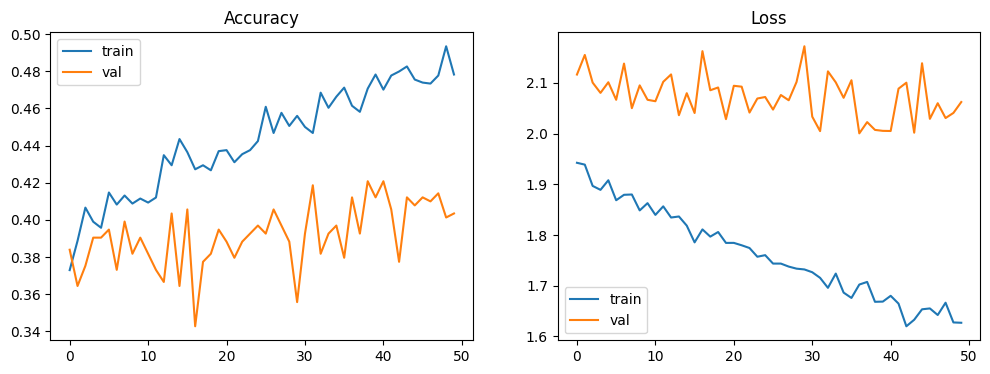

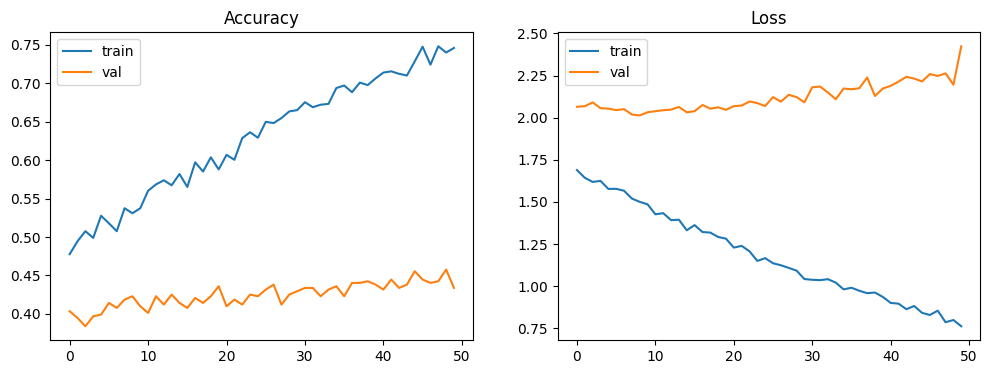

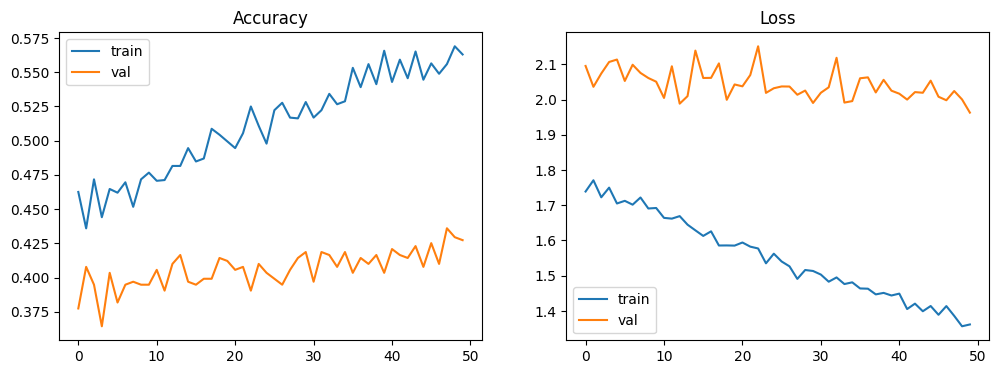

In [42]:
# Plot function generated by GPT
def plot_history(history):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12,4))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title("Loss")
    plt.legend()
    plt.show()

history_cnn1 = cnn1.fit(
    ds_train,
    epochs=50,
    verbose=1,
    validation_data=ds_val
)
history_cnn3 = cnn3.fit(
    ds_train,
    epochs=50,
    verbose=1,
    validation_data=ds_val
)
history_cnn2 = cnn2.fit(
    ds_train,
    epochs=50,
    verbose=1,
    validation_data=ds_val
)
history_cnn4 = cnn4.fit(
    ds_train,
    epochs=50,
    verbose=1,
    validation_data=ds_val
)
plot_history(history_cnn1)
plot_history(history_cnn2)
plot_history(history_cnn3)
plot_history(history_cnn4)

**Statistical Comparison**

In [43]:
# Statistical comparison code adapted from Claude AI

from statsmodels.stats.contingency_tables import mcnemar
from itertools import combinations

pred_cnn1 = np.argmax(cnn1.predict(ds_val), axis=1)
pred_cnn2 = np.argmax(cnn2.predict(ds_val), axis=1)
pred_cnn3 = np.argmax(cnn3.predict(ds_val), axis=1)
pred_cnn4 = np.argmax(cnn4.predict(ds_val), axis=1)

y_true = np.concatenate([y for x, y in ds_val], axis=0)

predictions = {
    'CNN1': pred_cnn1,
    'CNN2': pred_cnn2,
    'CNN3': pred_cnn3,
    'CNN4': pred_cnn4
}

bonferroni_alpha = 0.05 / 6

print("="*70)
print("McNemar's Test - Pairwise Model Comparisons")
print("="*70)
print(f"Bonferroni-corrected significance level: α = {bonferroni_alpha:.5f}")
print("="*70)

results = []
for (name1, pred1), (name2, pred2) in combinations(predictions.items(), 2):
    correct_1 = (pred1 == y_true)
    correct_2 = (pred2 == y_true)

    n_both_correct = np.sum(correct_1 & correct_2)
    n_1_only = np.sum(correct_1 & ~correct_2)
    n_2_only = np.sum(~correct_1 & correct_2)
    n_both_wrong = np.sum(~correct_1 & ~correct_2)

    table = [[n_both_correct, n_1_only],
             [n_2_only, n_both_wrong]]

    result = mcnemar(table, exact=True)

    acc1 = np.mean(correct_1)
    acc2 = np.mean(correct_2)

    results.append({
        'comparison': f"{name1} vs {name2}",
        'acc1': acc1,
        'acc2': acc2,
        'diff': acc1 - acc2,
        'p_value': result.pvalue,
        'significant': result.pvalue < bonferroni_alpha,
        'table': table
    })

    print(f"\n{name1} vs {name2}")
    print(f"  {name1} accuracy: {acc1:.4f}")
    print(f"  {name2} accuracy: {acc2:.4f}")
    print(f"  Difference: {acc1 - acc2:+.4f}")
    print(f"  Contingency table:")
    print(f"    Both correct: {n_both_correct}, {name1} only: {n_1_only}")
    print(f"    {name2} only: {n_2_only}, Both wrong: {n_both_wrong}")
    print(f"  p-value: {result.pvalue:.6f}")
    print(f"  Significant (α={bonferroni_alpha:.5f}): {'YES' if result.pvalue < bonferroni_alpha else 'NO'}")

print("\n" + "="*70)
print("SUMMARY")
print("="*70)
print(f"{'Comparison':<20} {'Acc 1':<10} {'Acc 2':<10} {'Diff':<10} {'p-value':<12} {'Sig?'}")
print("-"*70)
for r in results:
    sig_marker = "***" if r['significant'] else ""
    print(f"{r['comparison']:<20} {r['acc1']:<10.4f} {r['acc2']:<10.4f} "
          f"{r['diff']:+<10.4f} {r['p_value']:<12.6f} {sig_marker}")
print("="*70)
print(f"*** = Significant at Bonferroni-corrected α = {bonferroni_alpha:.5f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
McNemar's Test - Pairwise Model Comparisons
Bonferroni-corrected significance level: α = 0.00833

CNN1 vs CNN2
  CNN1 accuracy: 0.4360
  CNN2 accuracy: 0.4035
  Difference: +0.0325
  Contingency table:
    Both correct: 129, CNN1 only: 72
    CNN2 only: 57, Both wrong: 203
  p-value: 0.217561
  Significant (α=0.00833): NO

CNN1 vs CNN3
  CNN1 accuracy: 0.4360
  CNN3 accuracy: 0.4338
  Difference: +0.0022
  Contingency table:
    Both correct: 164, CNN1 only: 37
    CNN3 only: 36, Both wrong: 224
  p-value: 1.000000
  Significant (α=0.00833): NO

CNN1 vs CNN4
  CNN1 accuracy: 0.4360
  CNN4 accuracy: 0.4273
  Difference: +0.0087
  Contingency table:
    Both correct: 137, CNN1 only: 64
    CNN4 only: 60, Both wrong: 200
  p-value: 0.787747
  Significant (α=0.00833): NO

CNN2 vs CNN3
  CNN2 accuracy: 0.4035
  CNN3 accuracy: 0.4338
 

Based on the pairwise statistical comparisons above, the null hypothesis cannot be rejected for any of the pairs and we cannot statistically say that the model perform differently.

**CNN vs. MLP**

In [48]:
# Multi-layer perceptron adapted from class lecture/11. Convolutional Neural Networks.ipynb

input_shape = [64,64,3]

mlp = Sequential(name='MLP')
mlp.add( Input(input_shape) )
mlp.add( Flatten() )
mlp.add( Dense( units=30,
               activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(NUM_CLASSES) )
mlp.add( Activation('softmax') )

mlp.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(ds_train,
        batch_size=32, epochs=150,
        shuffle=True, verbose=0)

In [74]:
mlp.summary()

Model: "MLP"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 12288)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 30)             │       368,670 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 15)             │           465 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 22)             │           352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 22)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 738,976 (2.82 MB)

 Trainable params: 369,487 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 369,489 (1.41 MB)

Evaluating CNN Models...
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

CNN1 Evaluation Results
Accuracy:   0.4360
F3-Score:  0.3697
Recall:    0.3721


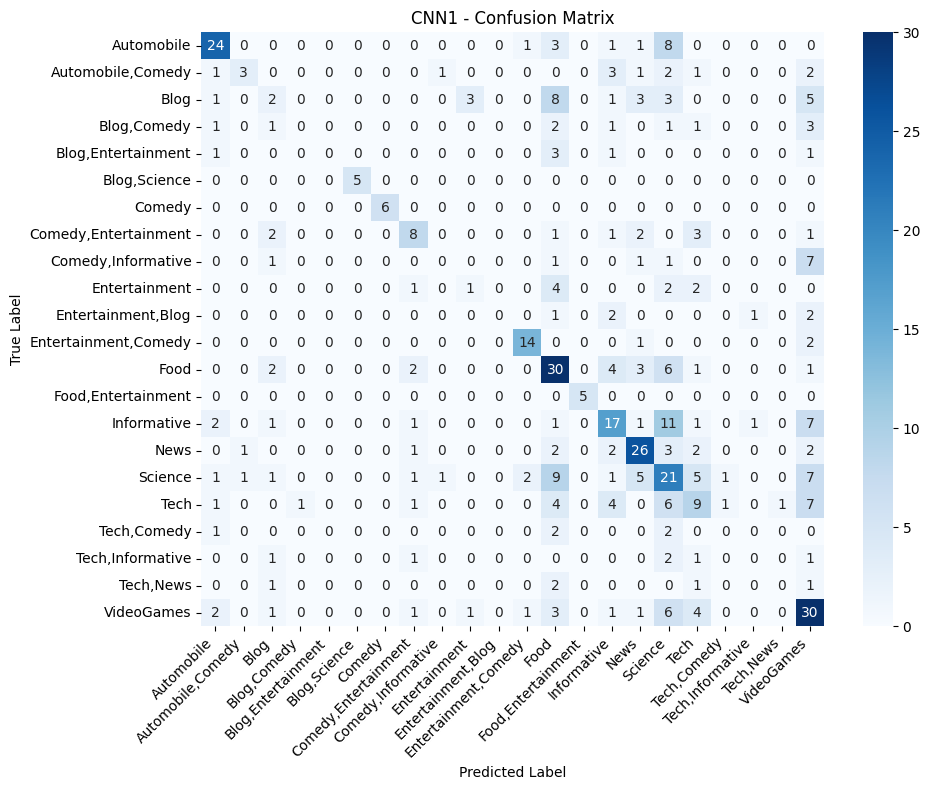

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

CNN2 Evaluation Results
Accuracy:   0.4035
F3-Score:  0.3456
Recall:    0.3489


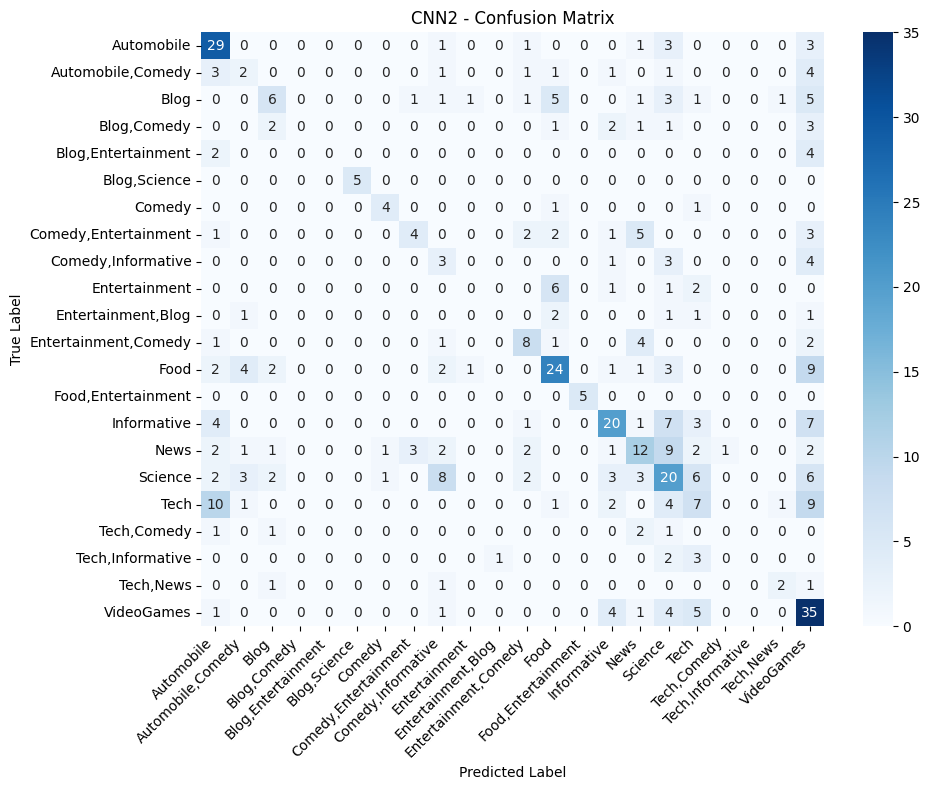

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

CNN3 Evaluation Results
Accuracy:   0.4338
F3-Score:  0.3642
Recall:    0.3654


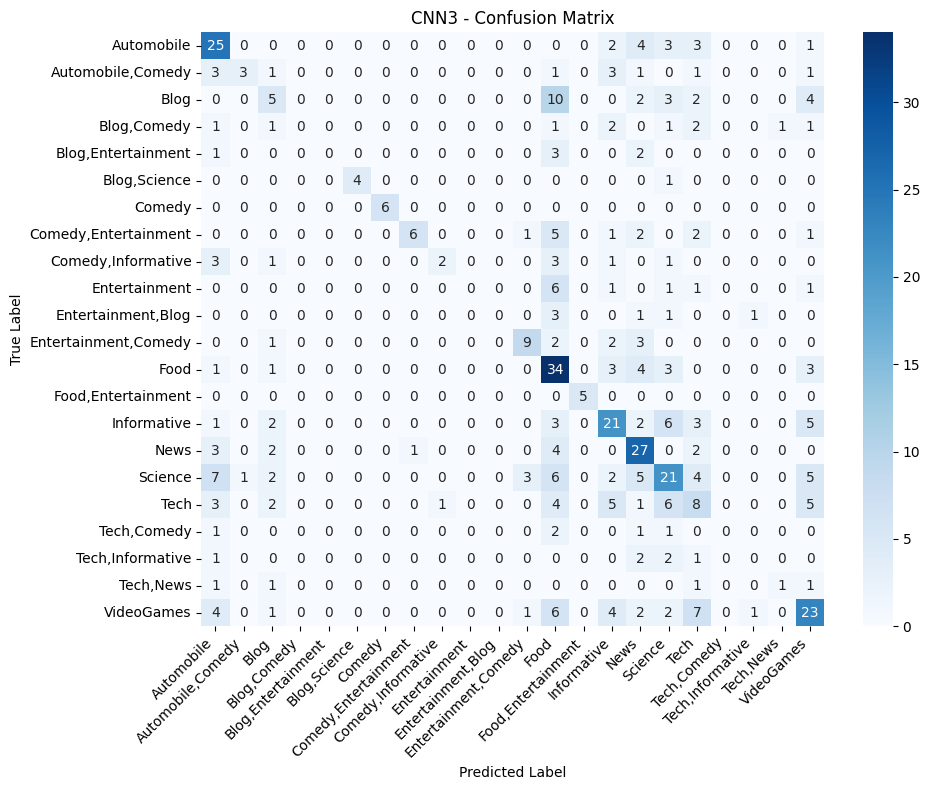

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step

CNN4 Evaluation Results
Accuracy:   0.4273
F3-Score:  0.3889
Recall:    0.3966


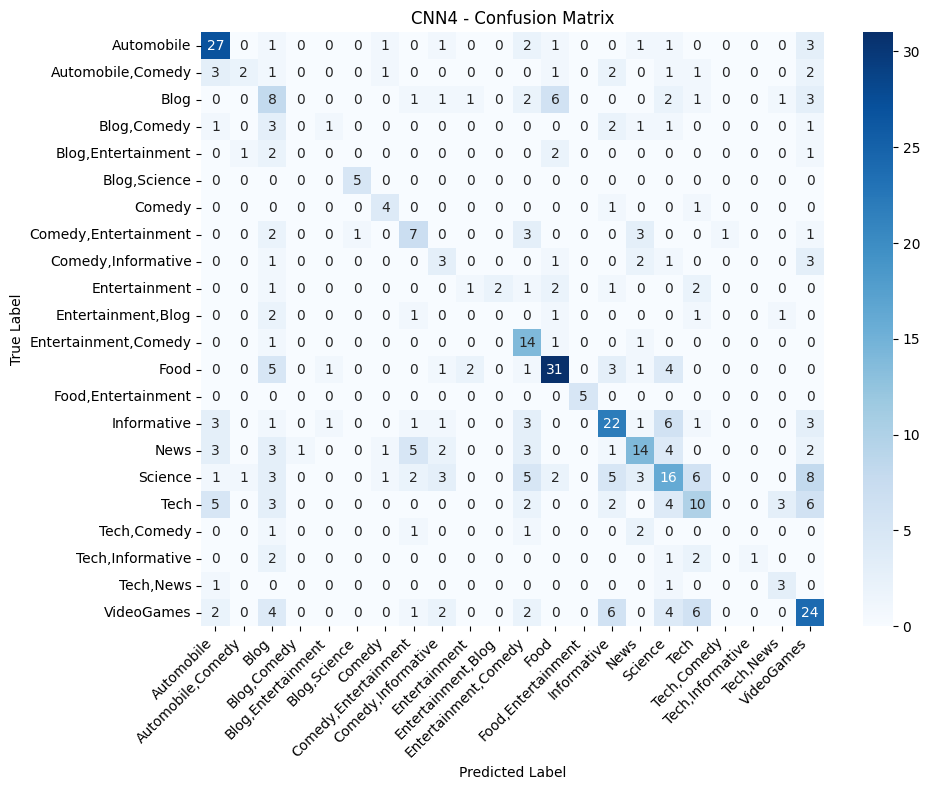

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

MLP Evaluation Results
Accuracy:   0.1345
F3-Score:  0.0391
Recall:    0.0561


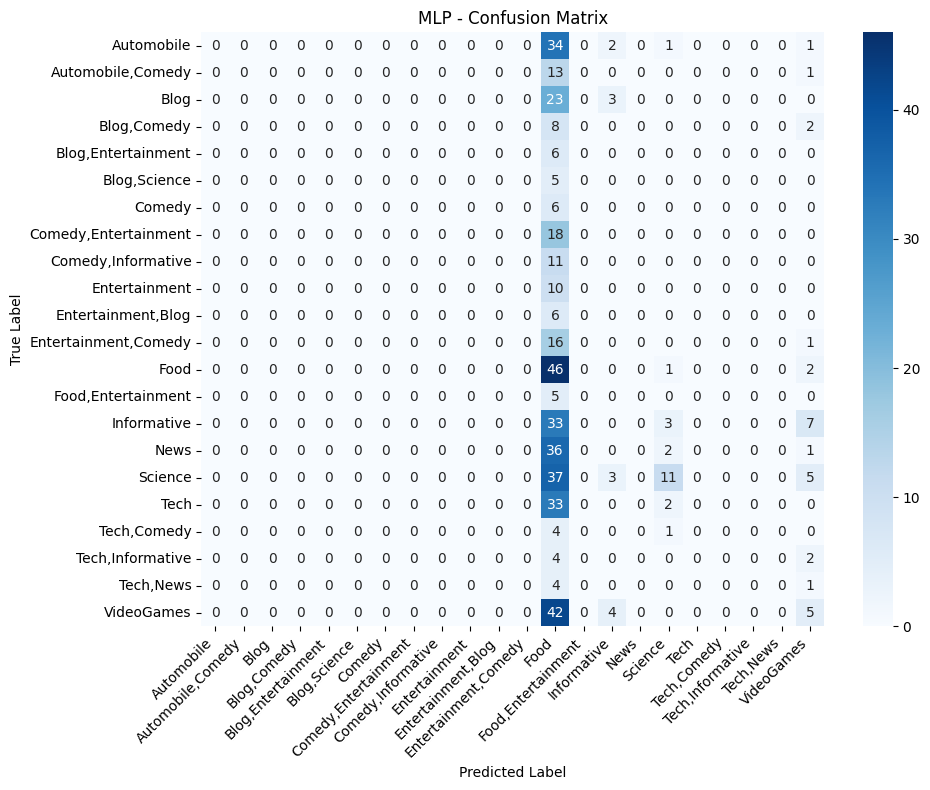

In [51]:
# Evaluation metrics: F3-score, Recall, and Confusion Matrix. This code is adapted from Github Copilot
# This code finds the precision, recall, and f3 score, as discussed in the evaluation metrics section.
# It outputs a table containing these metrics, each model's confusion matrix, and the three metrics for each column

from sklearn.metrics import fbeta_score, recall_score, confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, ds_val, y_true, model_name):
    """Evaluate model with F3-score, recall, and confusion matrix"""
    # Get predictions
    y_pred = np.argmax(model.predict(ds_val), axis=1)

    # Calculate F3-score
    f3 = fbeta_score(y_true, y_pred, beta=3, average='macro')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='macro')

    # Accuracy for comparison
    accuracy = np.mean(y_pred == y_true)

    print(f"\n{'='*60}")
    print(f"{model_name} Evaluation Results")
    print(f"{'='*60}")
    print(f"Accuracy:   {accuracy:.4f}")
    print(f"F3-Score:  {f3:.4f}")
    print(f"Recall:    {recall:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()


    return {
        'accuracy': accuracy,
        'f3': f3,
        'recall': recall,
        'predictions': y_pred
    }

# Evaluate all models
print("Evaluating CNN Models...")
results_cnn1 = evaluate_model(cnn1, ds_val, y_true, "CNN1")
results_cnn2 = evaluate_model(cnn2, ds_val, y_true, "CNN2")
results_cnn3 = evaluate_model(cnn3, ds_val, y_true, "CNN3")
results_cnn4 = evaluate_model(cnn4, ds_val, y_true, "CNN4")
results_mlp = evaluate_model(mlp, ds_val, y_true, "MLP")

In [52]:
# Summary comparison table generated by copilot
import pandas as pd

summary_data = {
    'Model': ['CNN1', 'CNN2', 'CNN3', 'CNN4', 'MLP'],
    'Accuracy': [results_cnn1['accuracy'], results_cnn2['accuracy'],
                 results_cnn3['accuracy'], results_cnn4['accuracy'], results_mlp['accuracy']],
    'F3-Score': [results_cnn1['f3'], results_cnn2['f3'],
                         results_cnn3['f3'], results_cnn4['f3'], results_mlp['f3']],
    'Recall': [results_cnn1['recall'], results_cnn2['recall'],
                       results_cnn3['recall'], results_cnn4['recall'], results_mlp['recall']],
}

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.sort_values('F3-Score', ascending=False)

print("\n" + "="*80)
print("MODEL PERFORMANCE SUMMARY (sorted by F3-Score)")
print("="*80)
print(summary_df.to_string(index=False))
print("\nBest model by F3-Score:", summary_df.iloc[0]['Model'])
print("="*80)


MODEL PERFORMANCE SUMMARY (sorted by F3-Score)
Model  Accuracy  F3-Score   Recall
 CNN4  0.427332  0.388879 0.396583
 CNN1  0.436009  0.369747 0.372064
 CNN3  0.433839  0.364160 0.365371
 CNN2  0.403471  0.345551 0.348864
  MLP  0.134490  0.039053 0.056057

Best model by F3-Score: CNN4


In [75]:
# CNN4 vs mlp statistical comparison adapted from Claude AI
from scipy.stats import bootstrap

pred_cnn4 = np.argmax(cnn4.predict(ds_val), axis=1)
pred_mlp = np.argmax(mlp.predict(ds_val), axis=1)
y_true = np.concatenate([y for x, y in ds_val], axis=0)

def f3_diff(*samples):
    y_true_sample = samples[0]
    pred_cnn4_sample = samples[1]
    pred_mlp_sample = samples[2]

    f3_cnn4 = fbeta_score(y_true_sample, pred_cnn4_sample, beta=3, average='macro', zero_division=0)
    f3_mlp = fbeta_score(y_true_sample, pred_mlp_sample, beta=3, average='macro', zero_division=0)
    return f3_cnn4 - f3_mlp

rng = np.random.default_rng(42)
res = bootstrap(
    (y_true, pred_cnn4, pred_mlp),
    f3_diff,
    n_resamples=10000,
    random_state=rng,
    method='percentile'
)

f3_cnn4 = fbeta_score(y_true, pred_cnn4, beta=3, average='macro')
f3_mlp = fbeta_score(y_true, pred_mlp, beta=3, average='macro')

print(f"CNN4 F3-score: {f3_cnn4:.4f}")
print(f"MLP F3-score: {f3_mlp:.4f}")
print(f"Difference: {f3_cnn4 - f3_mlp:+.4f}")
print(f"95% CI for difference: [{res.confidence_interval.low:.4f}, {res.confidence_interval.high:.4f}]")

# Check if 0 is outside the CI
significant = (res.confidence_interval.low > 0) or (res.confidence_interval.high < 0)
print(f"Significant: {'YES' if significant else 'NO'}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
CNN4 F3-score: 0.3889
MLP F3-score: 0.0391
Difference: +0.3498
95% CI for difference: [-0.0023, 0.0360]
Significant: NO


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

CNN4 - AUC (macro): 0.8784
CNN4 - AUC (micro): 0.9016

MLP  - AUC (macro): 0.5425
MLP  - AUC (micro): 0.7235

Difference (macro): +0.3359
Difference (micro): +0.1780


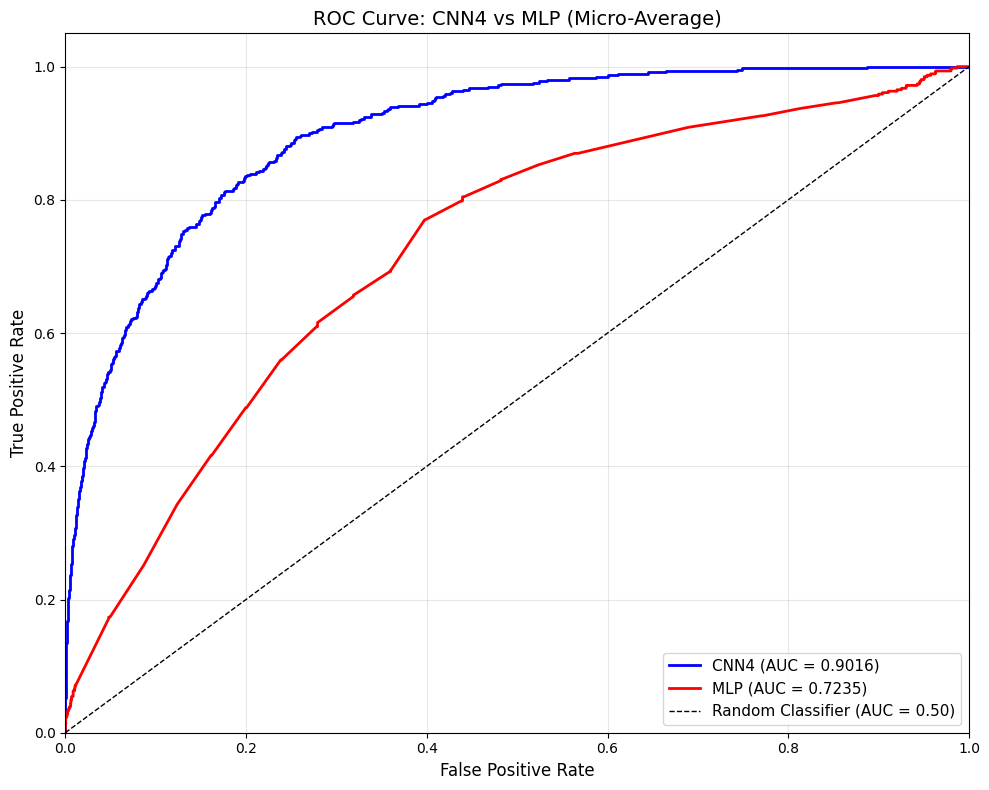

In [76]:
# ROC/AUC code generated by Claude AI

from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def compute_roc_auc(model, ds_val, y_true, model_name, num_classes):

    y_pred_proba = model.predict(ds_val)

    y_true_bin = label_binarize(y_true, classes=range(num_classes))

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_pred_proba.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    roc_auc["macro"] = np.mean([roc_auc[i] for i in range(num_classes)])

    return {
        'fpr': fpr,
        'tpr': tpr,
        'auc_macro': roc_auc["macro"],
        'auc_micro': roc_auc["micro"]
    }

roc_cnn4 = compute_roc_auc(cnn4, ds_val, y_true, "CNN4", NUM_CLASSES)
roc_mlp = compute_roc_auc(mlp, ds_val, y_true, "MLP", NUM_CLASSES)

print(f"\nCNN4 - AUC (macro): {roc_cnn4['auc_macro']:.4f}")
print(f"CNN4 - AUC (micro): {roc_cnn4['auc_micro']:.4f}")
print(f"\nMLP  - AUC (macro): {roc_mlp['auc_macro']:.4f}")
print(f"MLP  - AUC (micro): {roc_mlp['auc_micro']:.4f}")
print(f"\nDifference (macro): {roc_cnn4['auc_macro'] - roc_mlp['auc_macro']:+.4f}")
print(f"Difference (micro): {roc_cnn4['auc_micro'] - roc_mlp['auc_micro']:+.4f}")

plt.figure(figsize=(10, 8))

plt.plot(roc_cnn4['fpr']['micro'], roc_cnn4['tpr']['micro'],
         label=f"CNN4 (AUC = {roc_cnn4['auc_micro']:.4f})",
         linewidth=2, color='blue')

plt.plot(roc_mlp['fpr']['micro'], roc_mlp['tpr']['micro'],
         label=f"MLP (AUC = {roc_mlp['auc_micro']:.4f})",
         linewidth=2, color='red')

plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve: CNN4 vs MLP (Micro-Average)', fontsize=14)
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

Based on the graphic above, the CNN4 model is better at classifying labels than the MLP model. However, the f3-score statistical comparison resulted in a confidence interval that includes zero. Since CNN4 still has a higher rate of true positives than the MLP, CNN4 is better at classification according to the ROC curve, but the f3-score statistical comparison does not statistically show a difference in the f3-scores of the models.

### 4. Exceptional Work

4.1 *Use transfer learning with pre-trained weights for your initial layers of your CNN. These pre-trained weights should come from a well-known ImageNet trained model like ResNet, VGG, or SqueezeNet. Compare the performance when using transfer learning to your best model from above in terms of classification performance.*

We will use transfer learning with ResNet-50. This model was trained on ImageNet, which I doubt contains any youtube thumbnails, but it should be able to understand faces, objects, and words well enough. The problem with comparing our classifications is that ResNet50 was trained to recognize objects in an image while our model is trained to idenitfy more abstract concepts, the genre of a video.

Since neurons progressively learn abstract concepts the deeper a network gets, we can still use ResNet to classify youtube video genres. In our CNN, we have some layers that extract useful features about a thumbnail and use those concepts to classify a thumbnail to a genre. In this case, I'll use the pretrained weights of ResNet (and I'll keep them static) as the first layers of the network. These layers will find useful features according to the weights of ResNet and pass those on to some layers that I'll add on to ResNet. These added layers will use the features ResNet outputs to classify a genre.

While this way to classify YouTube thumbnail genres is probably contrived, it allows us to compare how ResNet might compare with our CNN in the same classification task.

In [53]:
# Code borrowed from (1)
# This code loads the weights of ResNet50, stored in tensorflow

# manipulated from Keras Documentation
#  https://keras.io/applications/
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import time

start_time = time.time()

res_model = ResNet50(weights='imagenet')
res_model.summary()

end_time = time.time()

print(f"Loaded in {end_time - start_time} seconds")

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_12[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 25,636,712 (97.80 MB)

 Trainable params: 25,583,592 (97.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

Loaded in 1.657888412475586 seconds


In [61]:
# Prepare 224x224 images for ResNet-50
# ResNet requires 224x224x3 RGB images
# Code below adapted from ChatGPT

import time

start_time = time.time()

# ResNet requires 224x224 input
resnet_size = (224, 224)
print(f"Preparing images for ResNet-50: {resnet_size} (with 3 color channels)")

# Create array to hold resized images for ResNet
X_resnet = np.zeros((len(images), resnet_size[0], resnet_size[1], 3), dtype=np.float32)

for i in range(len(images)):
    # Convert TensorFlow tensor to NumPy array if needed
    img = images[i]
    if hasattr(img, 'numpy'):  # Check if it's a TensorFlow tensor
        img = img.numpy()

    # Convert to RGB if image is grayscale or has alpha channel
    img_pil = Image.fromarray(img.astype(np.uint8))
    if img_pil.mode != 'RGB':
        img_pil = img_pil.convert('RGB')

    # Resize to 224x224 (keeps 3 RGB channels)
    img_resized = img_pil.resize(resnet_size, Image.Resampling.LANCZOS)
    img_array = np.array(img_resized, dtype=np.float32)

    # Store as 224x224x3 (no flattening for ResNet)
    # Will apply ResNet preprocessing later
    X_resnet[i] = img_array
end_time = time.time()
print(f"ResNet image preparation completed in {end_time - start_time:.2f} seconds")
print(f"ResNet dataset shape: {X_resnet.shape}")

Preparing images for ResNet-50: (224, 224) (with 3 color channels)
ResNet image preparation completed in 30.02 seconds
ResNet dataset shape: (2303, 224, 224, 3)


In [63]:
# Split ResNet data using same stratification as before
# split code below adapted from ChatGPT

X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet = train_test_split(
    X_resnet, y,
    test_size=0.2,
    stratify=y,
    shuffle=True,
    random_state=42
)

# Apply ResNet-specific ImageNet preprocessing
# This subtracts ImageNet mean and scales properly
from tensorflow.keras.applications.resnet50 import preprocess_input
X_train_resnet = preprocess_input(X_train_resnet.copy())
X_test_resnet = preprocess_input(X_test_resnet.copy())

# Encode labels for ResNet

y_train_resnet_int = le.transform(y_train_resnet)
print("Applied ImageNet preprocessing (mean subtraction & scaling)")

y_test_resnet_int = le.transform(y_test_resnet)
print("ResNet input shape:", X_train_resnet.shape[1:])

print("ResNet Test size:", len(X_test_resnet))
print("ResNet Train size:", len(X_train_resnet))

Applied ImageNet preprocessing (mean subtraction & scaling)
ResNet input shape: (224, 224, 3)
ResNet Test size: 461
ResNet Train size: 1842


In [64]:
# Code below adapted from ChatGPT

# Load ResNet-50 with pre-trained ImageNet weights
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

start_time = time.time()

# Load ResNet50 without the top classification layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the pre-trained layers
base_model.trainable = False

print(f"ResNet-50 loaded in {time.time() - start_time:.2f} seconds")
print(f"Total layers in base model: {len(base_model.layers)}")
print(f"Trainable: {base_model.trainable}")

ResNet-50 loaded in 1.08 seconds
Total layers in base model: 175
Trainable: False


In [65]:
# Code below adapted from ChatGPT

# Build transfer learning model with ResNet-50 base
from tensorflow.keras.layers import GlobalAveragePooling2D

resnet_model = keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
], name='ResNet50_Transfer_Learning')

resnet_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

resnet_model.summary()

Model: "ResNet50_Transfer_Learning"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 22)             │         2,838 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,147,990 (92.12 MB)

 Trainable params: 560,278 (2.14 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [66]:
# Code below adapted from ChatGPT

# Create TensorFlow datasets for ResNet
ds_train_resnet = tf.data.Dataset.from_tensor_slices((X_train_resnet, y_train_resnet_int))
ds_train_resnet = ds_train_resnet.shuffle(len(X_train_resnet), seed=42).batch(16).prefetch(AUTOTUNE)

ds_val_resnet = tf.data.Dataset.from_tensor_slices((X_test_resnet, y_test_resnet_int))
ds_val_resnet = ds_val_resnet.batch(16).prefetch(AUTOTUNE)

print("ResNet datasets created")
print("Training batches:", tf.data.experimental.cardinality(ds_train_resnet).numpy())
print("Validation batches:", tf.data.experimental.cardinality(ds_val_resnet).numpy())

ResNet datasets created
Training batches: 116
Validation batches: 29


Epoch 1/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 28s 142ms/step - accuracy: 0.0810 - loss: 3.4428 - val_accuracy: 0.2972 - val_loss: 2.6010
Epoch 2/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.2180 - loss: 2.6346 - val_accuracy: 0.3709 - val_loss: 2.3863
Epoch 3/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 56ms/step - accuracy: 0.2990 - loss: 2.4686 - val_accuracy: 0.3861 - val_loss: 2.2288
Epoch 4/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 57ms/step - accuracy: 0.3491 - loss: 2.2609 - val_accuracy: 0.4100 - val_loss: 2.1076
Epoch 5/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.3920 - loss: 2.1030 - val_accuracy: 0.4317 - val_loss: 2.0186
Epoch 6/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.4221 - loss: 2.0387 - val_accuracy: 0.4447 - val_loss: 1.9590
Epoch 7/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4605 - loss: 1.9178 - val_accuracy: 0.4881 - val_loss: 1.9047
Epoch 8/30
116/116 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4632 - loss: 1.8180 - val_ac

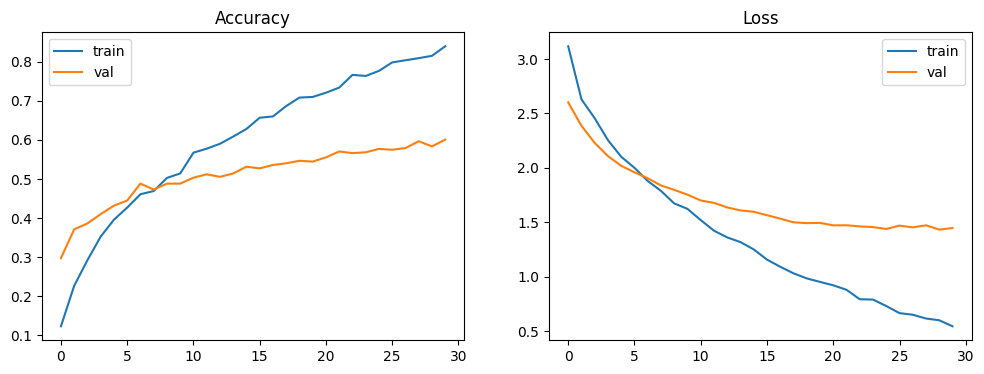

In [67]:
# Code below adapted from ChatGPT

# Train the ResNet transfer learning model
history_resnet = resnet_model.fit(
    ds_train_resnet,
    epochs=30,
    verbose=1,
    validation_data=ds_val_resnet
)

plot_history(history_resnet)


RESNET-50 TRANSFER LEARNING EVALUATION
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step

ResNet-50 Evaluation Results
Accuracy:   0.6009
F3-Score:  0.5475
Recall:    0.5447


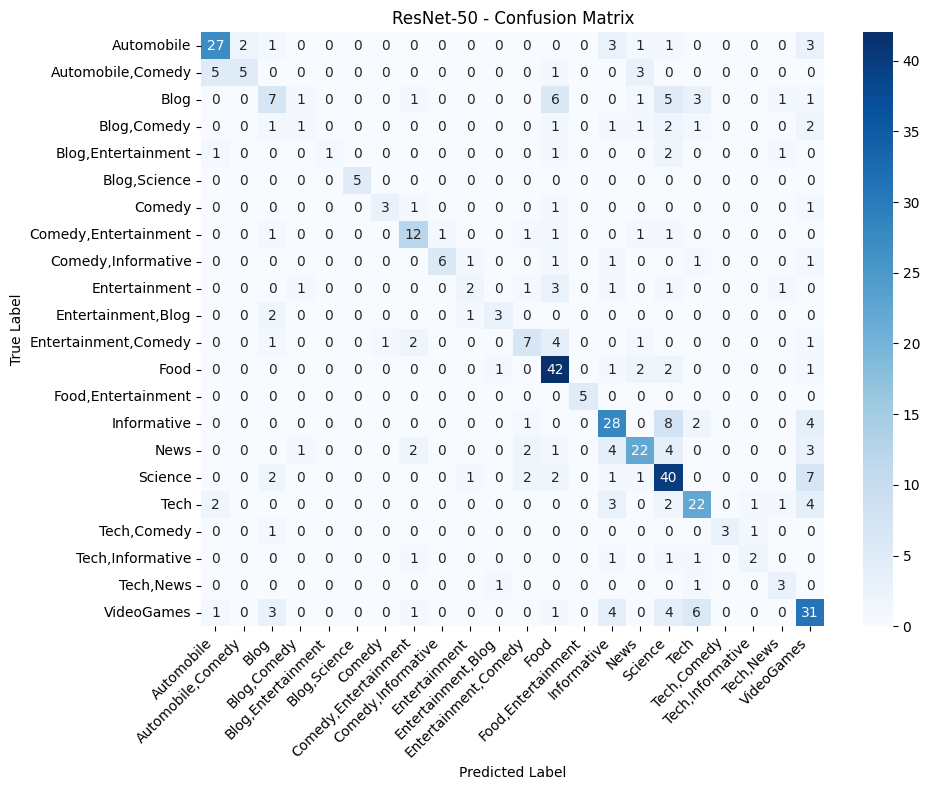


COMPARISON: ResNet-50 vs Best CNN (CNN4)
CNN4 F3-Score: 0.3889
ResNet50 F3-Score: 0.5475
Difference: +0.1587


In [70]:
# Code below adapted from ChatGPT

# Evaluate ResNet with comprehensive metrics
print("\n" + "="*80)
print("RESNET-50 TRANSFER LEARNING EVALUATION")
print("="*80)

y_true_resnet = np.concatenate([y for x, y in ds_val_resnet], axis=0)
results_resnet = evaluate_model(resnet_model, ds_val_resnet, y_true_resnet, "ResNet-50")

# Compare ResNet with best CNN using F3-score
pred_resnet = results_resnet['predictions']

# Calculate F3 scores for all models to find the best
f3_scores = {
    'CNN1': results_cnn1['f3'],
    'CNN2': results_cnn2['f3'],
    'CNN3': results_cnn3['f3'],
    'CNN4': results_cnn4['f3'],
    'MLP': results_mlp['f3'],
    'ResNet50': results_resnet['f3']
}

best_cnn_name = max(
    [(name, score) for name, score in f3_scores.items() if name != 'ResNet50'],
    key=lambda x: x[1]
)[0]

print(f"\n{'='*80}")
print(f"COMPARISON: ResNet-50 vs Best CNN ({best_cnn_name})")
print(f"{'='*80}")
print(f"{best_cnn_name} F3-Score: {f3_scores[best_cnn_name]:.4f}")
print(f"ResNet50 F3-Score: {f3_scores['ResNet50']:.4f}")
print(f"Difference: {f3_scores['ResNet50'] - f3_scores[best_cnn_name]:+.4f}")

The best CNN model (CNN4) had an F-3 score of 0.3889 while ResNet attained an F-3 score of 0.5475. This is a difference of 16%, which is very significant. ResNet-50 has been trained on millions more items than our model, so it's not surprising that it's doing this much better. Also, unlike our other models, ResNet deals with overfitting much better (the validation and training loss go down togerther, though the validation loss asymptotes sooner than the training).

Interestingly, it does its best job on food, science, informative, video games, and automobiles. food and automobiles make the most sense for ResNet to classify well, since many of the images it was trianed on include images of cars and food. Informative, science, and video games are a little less clear but could be explained as using common objects, hence ResNet's great ability at recalling them. There aren't too many noticable mistakes. The diagonal is discouragingly not a dark line, but it makes some sense why some of them are difficult to classify (such as the rows that have 2 categories, like blog, comedy. These are subsets of subsets, hence the difficulty in classifying them.) Blog has an almost equal number of contributions to food as to blog, which might imply that many of these blog thumbnails contain food (which would make some sense, especially if the blogs are about traveling or cooking).